Importation des librairies

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scprep
import scipy
from sklearn.decomposition import PCA
import scanpy as sc
import anndata
import umap
import seaborn as sns
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

Importation des données

In [2]:
df = pd.read_table("data.txt",delimiter=",",header=0,index_col=0)
print(df)
mito = pd.read_csv('list_mitochondrial_genes.txt',sep=';')
print(mito)

         AAACCCAAGAACTGAT  AAACCCAAGGGAGGGT  AAACCCAAGTCACAGG  \
CG15322                 1                 0                 0   
CG33217                 2                 0                 0   
Vps11                   4                 0                 0   
RpL10                 468                15                10   
G9a                    13                 0                 0   
...                   ...               ...               ...   
Pino                    3                 0                 1   
CG4629                  0                 0                 0   
S                      16                 0                 0   
CG2839                  0                 0                 0   
Nnf1b                   1                 0                 0   

         AAACCCAAGTCGCCCA  AAACCCACAGGTGTGA  AAACCCACATAATCCG  \
CG15322                 0                 0                 0   
CG33217                 1                 0                 0   
Vps11                   

Description des données

14503.886655179016
41895.24201832767
7969.051125604881
69061.28590398599


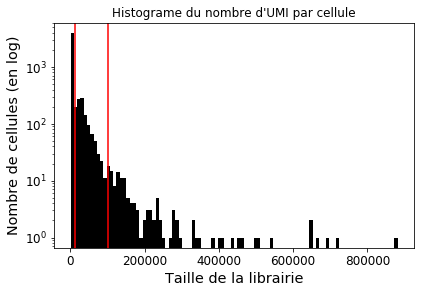

In [3]:
## Nombre d'UMI par cellule
print(np.mean(df.sum(axis=0)))
print(np.std(df.sum(axis=0)))

##Nombre d'UMI par gène
print(np.mean(df.sum(axis=1)))
print(np.std(df.sum(axis=1)))

scprep.plot.plot_library_size(df.transpose(),log='y',xlabel='Taille de la librairie',ylabel='Nombre de cellules (en log)',cutoff=[12000,100000],bins=100,color='black')
plt.title("Histograme du nombre d'UMI par cellule")
plt.savefig('prehistograme.eps')

14503.886655179016


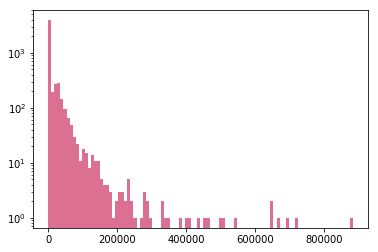

In [4]:
## Autre façon de faire les plots
nb_UMI = (df.sum(axis=0)) # axe 0 = par colonne
print(np.mean(nb_UMI))

plt.hist(nb_UMI,bins=100,color='palevioletred',log=False)
plt.yscale('log')

plt.show()


7969.051125604881
69061.28590398599


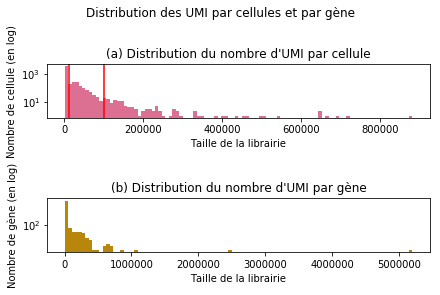

In [5]:
## UMI par gène 
nb_UMIg = (df.sum(axis=1))
print(np.mean(nb_UMIg))
print(np.std(nb_UMIg))


fig, axs = plt.subplots(2,1, constrained_layout=True)
axs[0].hist(nb_UMI,bins=100,color='palevioletred',log=False)
axs[0].set_yscale('log')
axs[0].set_ylabel("Nombre de cellule (en log)")
axs[0].set_xlabel('Taille de la librairie')
axs[0].axvline(x=12000, color='r', linestyle='-')
axs[0].axvline(x=100000, color='r', linestyle='-')

axs[0].set_title("(a) Distribution du nombre d'UMI par cellule")


axs[1].hist(nb_UMIg,bins=100,color='darkgoldenrod',log=False)
axs[1].set_yscale('log')
axs[1].set_ylabel("Nombre de gène (en log)")
axs[1].set_xlabel('Taille de la librairie')
axs[1].set_title("(b) Distribution du nombre d'UMI par gène")


fig.suptitle("Distribution des UMI par cellules et par gène")

plt.savefig('umipargene.eps')

plt.show()


##### Methode 1 scprep

[]

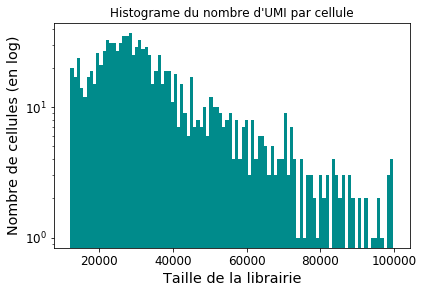

In [6]:
df = scprep.filter.filter_library_size(df.transpose(), cutoff=[12000,100000], keep_cells='between')
scprep.plot.plot_library_size(df,log='y',xlabel='Taille de la librairie',ylabel='Nombre de cellules (en log)',bins=100,color='darkcyan')
plt.title("Histograme du nombre d'UMI par cellule")
plt.savefig('filtre1.eps')
plt.plot()

In [7]:
df = df.transpose()
print(df)

         AAACCCAGTTGCGTAT  AAACGAACAGGCTTGC  AAACGAATCACATTGG  \
CG15322                 0                 0                 0   
CG33217                 1                 0                 0   
Vps11                   0                 3                 1   
RpL10                 177                47               125   
G9a                     3                 2                 4   
...                   ...               ...               ...   
Pino                    1                 0                 5   
CG4629                  0                 0                 0   
S                       1                 1                 6   
CG2839                  0                 0                 0   
Nnf1b                   0                 0                 1   

         AAACGCTGTTGGGACA  AAAGAACTCTATCACT  AAAGGATAGGATGGCT  \
CG15322                 0                 0                 0   
CG33217                 0                 4                 0   
Vps11                   

#### Methode 2 : Sans package

In [8]:
nb_UMI = (df.sum(axis=0))
df.drop(df.columns[np.where(nb_UMI<12000)],axis=1, inplace=True)
nb_UMI = (df.sum(axis=0))
df.drop(df.columns[np.where(nb_UMI>100000)],axis=1, inplace=True)
nb_UMI = (df.sum(axis=0))


Filtrage des gènes mitochondriaux

In [9]:
mito2= mito.columns.tolist()
print(mito2)

['MTPAP', 'mTerf3', 'COX5B', 'Mtpalpha', 'mTTF', 'COX4', 'COX7A', 'mtTFB2', 'COX5A', 'mTerf5', 'COX7C', 'mtDNA-helicase', 'ND2', 'trnC', 'trnY', 'COX1', 'COX2', 'ATP8', 'ATP6', 'COX3', 'ND3', 'trnR', 'ND5', 'ND4L', 'ND6', 'CYTB', 'ND1', 'trnL2', 'lrRNA', 'trnV', 'srRNA', 'mtRNApol', 'ND4', 'Mtch', 'COX8', 'COX6B']


In [10]:
def proportion (x,gene):
    p = (x/gene) * 100
    return p

nb_UMI = (df.sum(axis=0))
print(nb_UMI)

AAACCCAGTTGCGTAT    35072
AAACGAACAGGCTTGC    17939
AAACGAATCACATTGG    45686
AAACGCTGTTGGGACA    41870
AAAGAACTCTATCACT    70280
                    ...  
TTTCCTCTCAATCAGC    31182
TTTCCTCTCATGCAGT    48671
TTTCGATAGAAGGCTC    51752
TTTGGAGTCGGCCCAA    25746
TTTGGTTAGGGATCTG    62952
Length: 1100, dtype: int64


In [11]:
print(df)

         AAACCCAGTTGCGTAT  AAACGAACAGGCTTGC  AAACGAATCACATTGG  \
CG15322                 0                 0                 0   
CG33217                 1                 0                 0   
Vps11                   0                 3                 1   
RpL10                 177                47               125   
G9a                     3                 2                 4   
...                   ...               ...               ...   
Pino                    1                 0                 5   
CG4629                  0                 0                 0   
S                       1                 1                 6   
CG2839                  0                 0                 0   
Nnf1b                   0                 0                 1   

         AAACGCTGTTGGGACA  AAAGAACTCTATCACT  AAAGGATAGGATGGCT  \
CG15322                 0                 0                 0   
CG33217                 0                 4                 0   
Vps11                   

In [12]:
i = 0
list = []
for c in df.columns:
    test1 = 0
    for y in df.index : 
        if y in mito2 :
            test1 += df.loc[y,c]
    list.append(proportion(test1,nb_UMI[i]))
    i+=1
print(list)


[7.458941605839415, 8.03835219354479, 3.3336251805804844, 3.747313112013375, 6.804211724530449, 3.7641386983126273, 3.707865168539326, 6.840468156895825, 3.9819195525616897, 4.407655401486793, 7.601528622062055, 5.786426503698939, 6.794208034552451, 5.3005740801332575, 3.6638593471445255, 7.290929865607487, 2.1898790864308104, 4.873554093898843, 2.1783772239654353, 3.2953818104234154, 7.839458756795084, 4.851273271988017, 3.5043495452748123, 4.678793838085873, 4.487007318874639, 4.518220772818626, 3.6354056902002108, 3.6926935761066466, 7.993301474492505, 5.14664322049865, 7.4095662609291955, 3.9029108039809066, 1.6580214894405334, 4.168067226890757, 5.971408716370495, 4.049744897959184, 3.1684594266168595, 4.519723245574625, 7.3517382413087935, 3.8280236641462873, 7.739121614768233, 5.549519794880709, 6.7250897579430955, 4.138003465840466, 4.567630629993637, 6.366342351948109, 3.9988315102729723, 4.655005941770648, 7.036369593709043, 13.593073593073592, 6.28245067497404, 5.50162946350

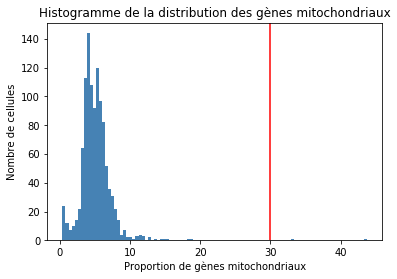

In [13]:
plt.hist(list, bins=100, color='steelblue')

plt.axvline(x=30, color='r', linestyle='-')
plt.xlabel('Proportion de gènes mitochondriaux')
plt.ylabel('Nombre de cellules')
plt.title('Histogramme de la distribution des gènes mitochondriaux')
plt.savefig('tamaman.eps')
plt.show()

In [14]:
genemito = np.array(list)
print(np.where(genemito > 30))

(array([358, 573]),)


In [15]:
larger = [i for i in genemito if i > 30] 
print(larger)

[43.7288869640537, 33.10149269701996]


In [16]:
df.drop(df.columns[np.where(genemito > 30)],axis=1,inplace=True)
print(df)

         AAACCCAGTTGCGTAT  AAACGAACAGGCTTGC  AAACGAATCACATTGG  \
CG15322                 0                 0                 0   
CG33217                 1                 0                 0   
Vps11                   0                 3                 1   
RpL10                 177                47               125   
G9a                     3                 2                 4   
...                   ...               ...               ...   
Pino                    1                 0                 5   
CG4629                  0                 0                 0   
S                       1                 1                 6   
CG2839                  0                 0                 0   
Nnf1b                   0                 0                 1   

         AAACGCTGTTGGGACA  AAAGAACTCTATCACT  AAAGGATAGGATGGCT  \
CG15322                 0                 0                 0   
CG33217                 0                 4                 0   
Vps11                   

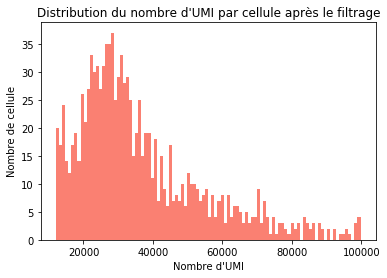

In [17]:
nb_UMI = (df.sum(axis=0))
plt.hist(nb_UMI,bins=100,color='salmon')
plt.xlabel("Nombre d'UMI")
plt.ylabel("Nombre de cellule")
plt.title("Distribution du nombre d'UMI par cellule après le filtrage")
plt.savefig("dffiltre.eps")
plt.show()

Nombre médian d'UMI 

In [18]:
nb_UMI = (df.sum(axis=0))
M=np.median(nb_UMI)
print(M)

31193.0


Normalisation des données

In [19]:
def normalisation(x):
    xnorm = np.log(((x / x.sum()) * M) + 1)
    return xnorm


dfnorm = df.apply(normalisation, axis=0)

print(dfnorm)

         AAACCCAGTTGCGTAT  AAACGAACAGGCTTGC  AAACGAATCACATTGG  \
CG15322          0.000000          0.000000          0.000000   
CG33217          0.636259          0.000000          0.000000   
Vps11            0.000000          1.827209          0.520441   
RpL10            5.065273          4.415526          4.458364   
G9a              1.299700          1.499104          1.316697   
...                   ...               ...               ...   
Pino             0.636259          0.000000          1.484747   
CG4629           0.000000          0.000000          0.000000   
S                0.636259          1.007533          1.628577   
CG2839           0.000000          0.000000          0.000000   
Nnf1b            0.000000          0.000000          0.520441   

         AAACGCTGTTGGGACA  AAAGAACTCTATCACT  AAAGGATAGGATGGCT  \
CG15322          0.000000          0.000000          0.000000   
CG33217          0.000000          1.020779          0.000000   
Vps11            0.00000

Plot des données filtrée et normalisée

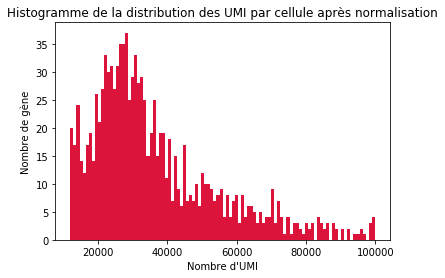

In [20]:
nb_UMInorm = (df.sum(axis=0))


plt.hist(nb_UMInorm,bins=100,color='crimson')
plt.xlabel("Nombre d'UMI")
plt.ylabel('Nombre de gène')
plt.title('Histogramme de la distribution des UMI par cellule après normalisation')
plt.savefig('donnenorm.eps')
plt.show()

Coefficient de variation

In [21]:
var = scipy.stats.variation(dfnorm,axis = 1)
print(var)
print(max(var))

[14.24859893  1.34477665  1.27984686 ...  0.79540577 11.68919598
  1.84372833]
33.12099032335966


/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/scipy/stats/stats.py:1040: RuntimeWarning: invalid value encountered in true_divide
  return a.std(axis) / a.mean(axis)


/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


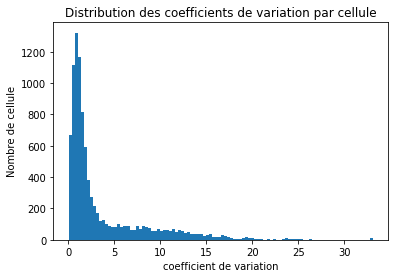

In [22]:
plt.hist(var,bins=100)
plt.xlabel('coefficient de variation')
plt.ylabel('Nombre de cellule')
plt.title('Distribution des coefficients de variation par cellule')
plt.savefig('coefvar.eps')
plt.show()


Les 1500 gènes les plus variables

In [23]:
dfnorm['variation'] = var
df2 = dfnorm.sort_values(by='variation', ascending=False).iloc[:1499]
print(df2)

                      AAACCCAGTTGCGTAT  AAACGAACAGGCTTGC  AAACGAATCACATTGG  \
CR43480                            0.0               0.0               0.0   
CG15210                            0.0               0.0               0.0   
CG34291                            0.0               0.0               0.0   
CG4716                             0.0               0.0               0.0   
5.8SrRNA-Psi:CR45863               0.0               0.0               0.0   
...                                ...               ...               ...   
CR45350                            0.0               0.0               0.0   
CR45126                            0.0               0.0               0.0   
CG14692                            0.0               0.0               0.0   
CG43293                            0.0               0.0               0.0   
CG14523                            0.0               0.0               0.0   

                      AAACGCTGTTGGGACA  AAAGAACTCTATCACT  AAAGG

In [24]:
print(df2.loc[:,'variation'])
df2.drop('variation', axis=1, inplace=True)

CR43480                 33.120990
CG15210                 33.120990
CG34291                 33.120990
CG4716                  33.120990
5.8SrRNA-Psi:CR45863    33.120990
                          ...    
CR45350                  8.072936
CR45126                  8.069119
CG14692                  8.066767
CG43293                  8.060435
CG14523                  8.058871
Name: variation, Length: 1499, dtype: float64


# ACP


Avec Sklearn

In [25]:
df3 = df2.transpose()

print(np.mean(df3,axis=0))

CR43480                 0.000541
CG15210                 0.001009
CG34291                 0.000750
CG4716                  0.000481
5.8SrRNA-Psi:CR45863    0.000653
                          ...   
CR45350                 0.012109
CR45126                 0.012293
CG14692                 0.012558
CG43293                 0.011727
CG14523                 0.014987
Length: 1499, dtype: float64


In [26]:
print(np.std(df3,axis=0))

CR43480                 0.017907
CG15210                 0.033430
CG34291                 0.024829
CG4716                  0.015948
5.8SrRNA-Psi:CR45863    0.021636
                          ...   
CR45350                 0.097754
CR45126                 0.099191
CG14692                 0.101299
CG43293                 0.094521
CG14523                 0.120777
Length: 1499, dtype: float64


In [27]:
acp = PCA(svd_solver='full')
coord = acp.fit_transform(df3)
print(acp.n_components_) 
print(acp.explained_variance_)

1098
[1.17198333e+00 6.01646715e-01 3.24590757e-01 ... 2.31133106e-31
 9.80074255e-33 1.72026176e-33]


Valeur corrigée

[1.17091595e+00 6.01098767e-01 3.24295137e-01 ... 2.30922602e-31
 9.79181655e-33 1.71869504e-33]
[1.17091595e+00 6.01098767e-01 3.24295137e-01 ... 2.30922602e-31
 9.79181655e-33 1.71869504e-33]
[1.15843461e-01 5.94691374e-02 3.20838323e-02 ... 2.28461090e-32
 9.68744100e-34 1.70037466e-34]


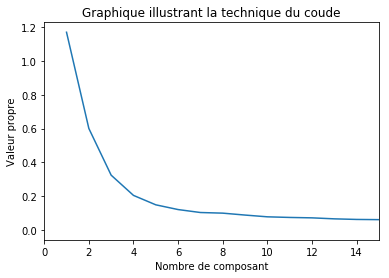

In [28]:
n = acp.n_components_
eigval = (n-1)/n*acp.explained_variance_
print(eigval)
print(acp.singular_values_**2/n)

print(acp.explained_variance_ratio_)

p = 1098

plt.plot(np.arange(1,p+1),eigval) 
plt.title("Graphique illustrant la technique du coude") 
plt.xlim(0,15)
plt.ylabel("Valeur propre") 
plt.xlabel("Nombre de composant") 
plt.savefig('eigvalue.eps')
plt.show()

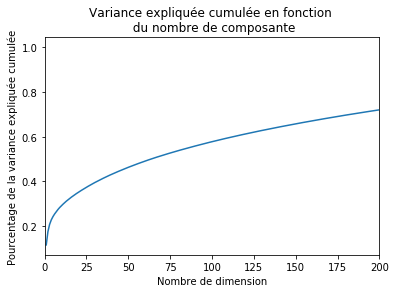

In [29]:
plt.plot(np.arange(1,p+1),np.cumsum(acp.explained_variance_ratio_)) 
plt.title("Variance expliquée cumulée en fonction \n du nombre de composante")
plt.ylabel("Pourcentage de la variance expliquée cumulée")
plt.xlabel("Nombre de dimension")
plt.xlim(0,200)
plt.savefig('varcumule.eps')
plt.show()

In [30]:
#seuils pour test des bâtons brisés
bs = 1/np.arange(p,0,-1)
bs = np.cumsum(bs)
bs = bs[::-1]

In [31]:
print(pd.DataFrame({'Val.Propre':eigval,'Seuils':bs}))

        Val.Propre    Seuils
0     1.170916e+00  7.578917
1     6.010988e-01  6.578917
2     3.242951e-01  6.078917
3     2.044568e-01  5.745583
4     1.486399e-01  5.495583
...            ...       ...
1093  4.076184e-05  0.004562
1094  9.961580e-06  0.003648
1095  2.309226e-31  0.002735
1096  9.791817e-33  0.001822
1097  1.718695e-33  0.000911

[1098 rows x 2 columns]


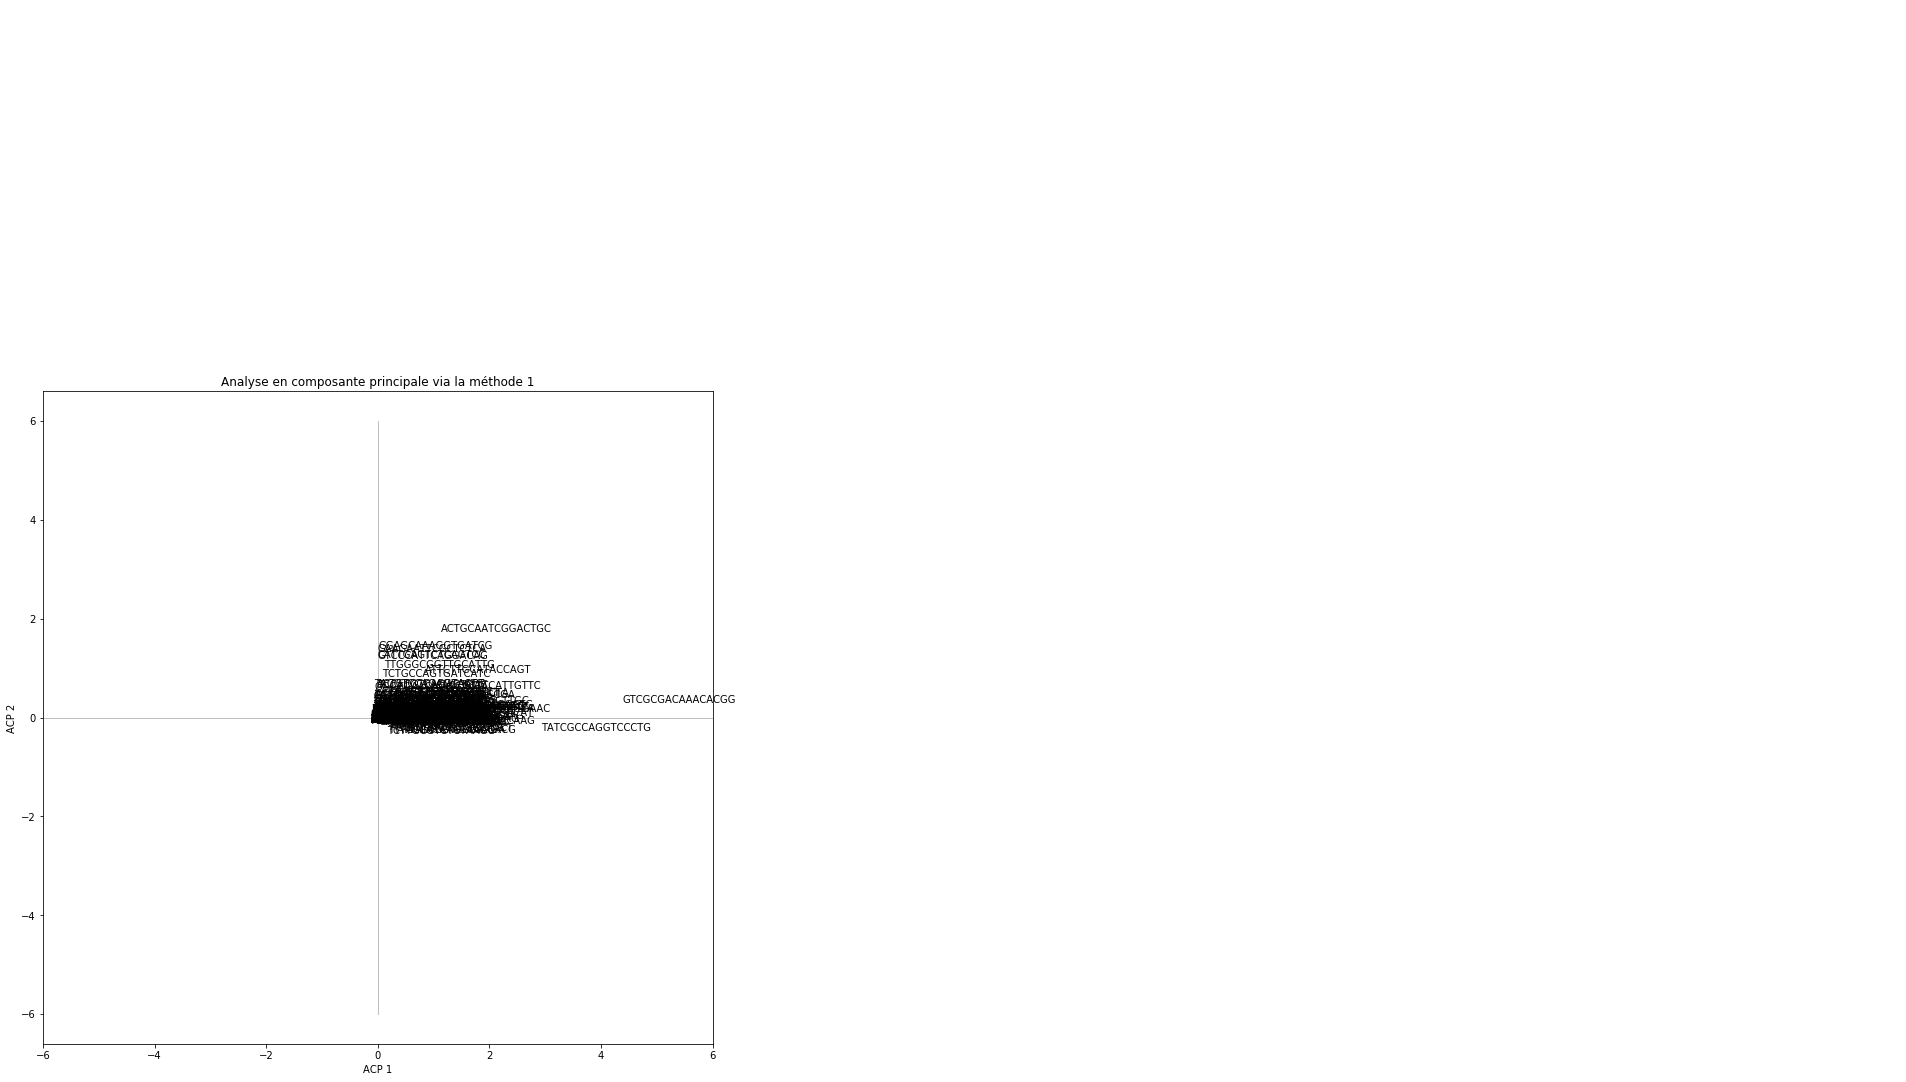

In [32]:
#positionnement des individus dans le premier plan
fig, axes = plt.subplots(figsize=(12,12)) 
axes.set_xlim(-6,6) #même limites en abscisse axes.set_ylim(-6,6) #et en ordonnée
#placement des étiquettes des observations
for i in range(n):
    plt.annotate(df3.index[i],(coord[i,0],coord[i,1]))
#ajouter les axes
plt.plot([-6,6],[0,0],color='silver',linestyle='-',linewidth=1) 
plt.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)
plt.xlabel('ACP 1')
plt.ylabel('ACP 2')
plt.title('Analyse en composante principale via la méthode 1')
#affichage
plt.savefig('acprate.eps')
plt.show()

Version avec Scanpy

## Methode 2 : Scanpy

#### visualisation test d'umap

In [33]:
dft = df2.transpose()
reducer = umap.UMAP()
embedding = reducer.fit_transform(dft)

(1098, 2)


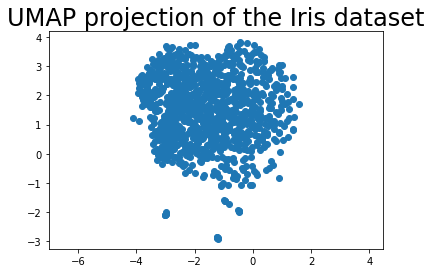

In [34]:
print(embedding.shape)
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Iris dataset', fontsize=24);


plt.show()


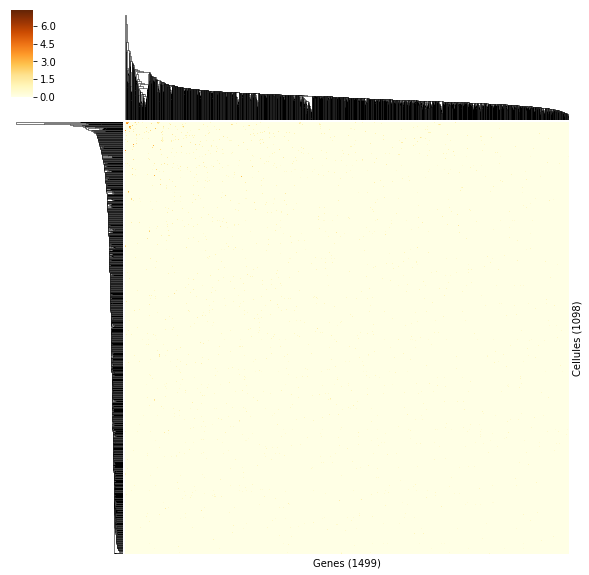

In [35]:
df4 = dft
cg = sns.clustermap(df4, cmap='YlOrBr', xticklabels=[], yticklabels=[])
cg.ax_heatmap.set_xlabel('Genes ({})'.format(df4.shape[1]))
cg.ax_heatmap.set_ylabel('Cellules ({})'.format(df4.shape[0]))
cg.savefig('heatmap.png')

Methode alternative pour filtrer les gènes les plus variables

AnnData object with n_obs × n_vars = 1098 * 9506
    var: 'gene_ids'


In [36]:
print(dfnorm)
dfnorm.drop('variation', axis=1, inplace=True)

         AAACCCAGTTGCGTAT  AAACGAACAGGCTTGC  AAACGAATCACATTGG  \
CG15322          0.000000          0.000000          0.000000   
CG33217          0.636259          0.000000          0.000000   
Vps11            0.000000          1.827209          0.520441   
RpL10            5.065273          4.415526          4.458364   
G9a              1.299700          1.499104          1.316697   
...                   ...               ...               ...   
Pino             0.636259          0.000000          1.484747   
CG4629           0.000000          0.000000          0.000000   
S                0.636259          1.007533          1.628577   
CG2839           0.000000          0.000000          0.000000   
Nnf1b            0.000000          0.000000          0.520441   

         AAACGCTGTTGGGACA  AAAGAACTCTATCACT  AAAGGATAGGATGGCT  \
CG15322          0.000000          0.000000          0.000000   
CG33217          0.000000          1.020779          0.000000   
Vps11            0.00000

In [37]:
adata=anndata.AnnData(dfnorm.transpose())

sc.pp.highly_variable_genes(adata, n_top_genes=1500,flavor='cell_ranger',subset=True)


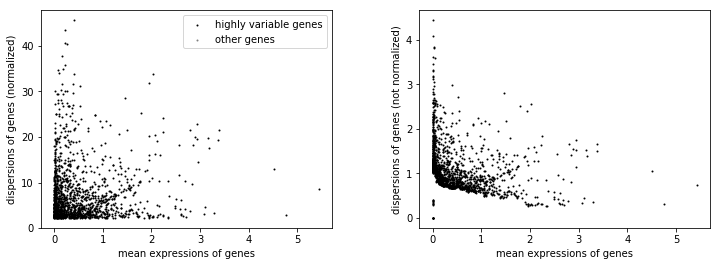

In [38]:
sc.pl.highly_variable_genes(adata,save=True)
g_variable=adata.var.highly_variable.index

In [39]:
print(adata)
print(g_variable)

AnnData object with n_obs × n_vars = 1098 × 1499 
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
Index(['CG15322', 'CG3777', 'y', 'ac', 'sc', 'ase', 'arg', 'Cyp4g1', 'CG13375',
       'Appl',
       ...
       'Ts', 'CG31689', 'daw', 'insv', 'dpp', 'Npc2a', 'CG5397', 'robo2',
       'MFS3', 'CG5080'],
      dtype='object', length=1499)


ACP avant filtrage (+ visualisation bonus en Umap et en louvain)

In [40]:
sc.tl.pca(adata,n_comps=8, svd_solver='auto')
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=8)

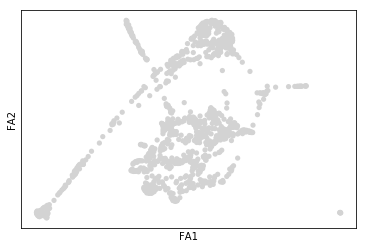

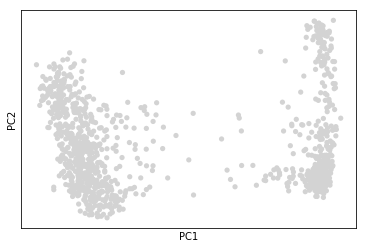

In [41]:
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata,save=True)


sc.pl.pca(adata,save=True)

/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


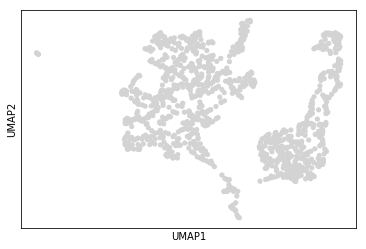

In [42]:

sc.tl.umap(adata)
sc.pl.umap(adata,save=True)

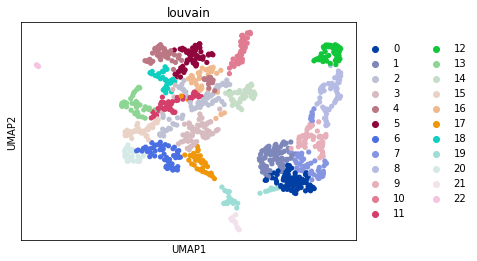

In [43]:
sc.tl.louvain(adata)

sc.pl.umap(adata, color=['louvain'])

In [44]:
andatafiltre=adata.var.highly_variable.index

In [45]:
df = dfnorm
pca=PCA(n_components=8) 

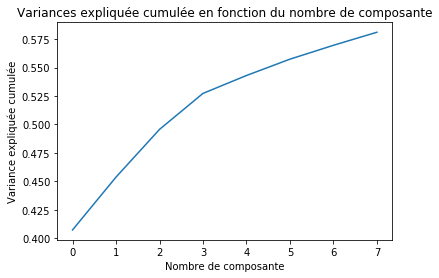

In [46]:
pca=pca.fit(df.loc[andatafiltre].transpose())

#Plot Cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composante')
plt.ylabel('Variance expliquée cumulée')
plt.title('Variances expliquée cumulée en fonction du nombre de composante')
plt.savefig('varmethode2.eps')
plt.show()

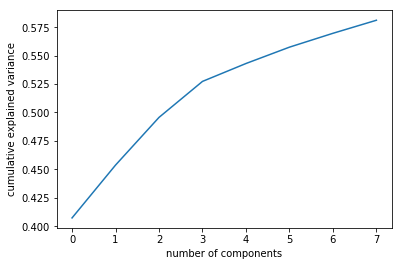

In [47]:
pca=PCA(n_components=8) 
pca=pca.fit(df.loc[andatafiltre].transpose())

#Plot Cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

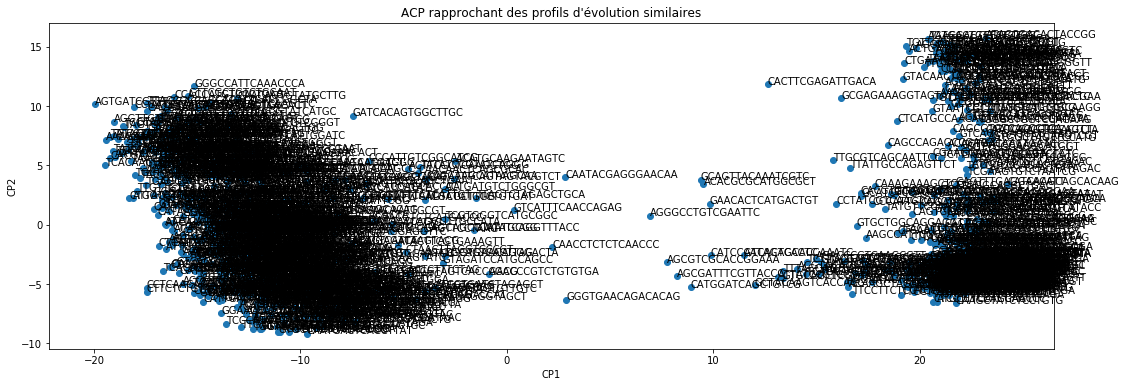

In [48]:
coord = pca.transform(df.loc[andatafiltre].transpose())
plt.figure(figsize=(18,6))
plt.scatter(coord[:, 0], coord[:, 1])

for i in range(n):
    plt.annotate(df.loc[andatafiltre].columns[i],(coord[i,0],coord[i,1]))
plt.xlabel('CP1')
plt.ylabel('CP2')
plt.title("ACP rapprochant des profils d'évolution similaires")
plt.savefig('acpbonus.png')
plt.show()

/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/scprep/reduce.py:289: FutureWarning: n_pca is deprecated. Setting n_components=8.
  "n_pca is deprecated. Setting n_components={}.".format(n_pca), FutureWarning


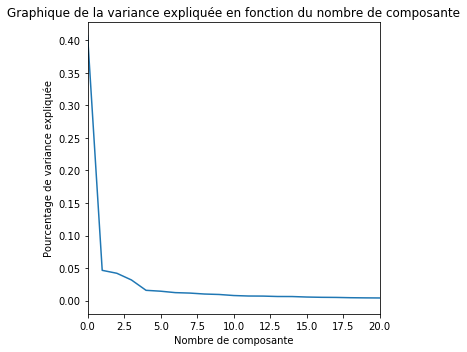

In [49]:
data_pcs = scprep.reduce.pca(dfnorm, n_pca=8)
pc_op = PCA()
data_pcs = pc_op.fit_transform(dfnorm.loc[g_variable].transpose())
fig, ax = plt.subplots(1, figsize=(6,5))

# plot explained variance as a fraction of the total explained variance
ax.plot(pc_op.explained_variance_/pc_op.explained_variance_.sum())

# mark the 100th principal component
ax.axvline(100, c='k', linestyle='--')

ax.set_xlabel('Nombre de composante')
ax.set_ylabel('Pourcentage de variance expliquée')
ax.set_title('Graphique de la variance expliquée en fonction du nombre de composante')
ax.set_xlim(0,20)
plt.savefig('explainetest.eps')
fig.tight_layout()

Autre visualisation de l'ACP

78.61337630331869


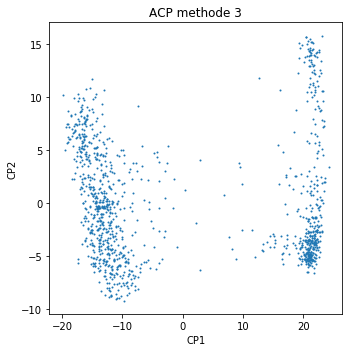

In [50]:
print(pc_op.explained_variance_.cumsum()[100]/pc_op.explained_variance_.sum() * 100)
fig, ax = plt.subplots(1, figsize=(5,5))

ax.scatter(data_pcs[:,0], data_pcs[:,1], s=1)
ax.set_xlabel('CP1')
ax.set_ylabel('CP2')
ax.set_title('ACP methode 3')

fig.tight_layout()

Figure bonus du tutorial, pas important

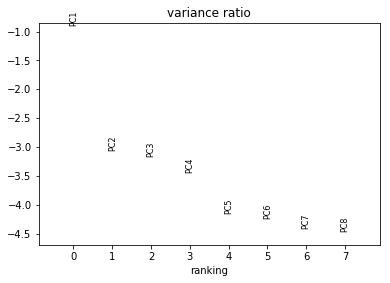

In [51]:
sc.pl.pca_variance_ratio(adata, log=True)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=8)

In [52]:
# gènes essentiellement exprimés dans les muscles
list_muscle  = ["blow","Grip","Him","htl","Pdp1", "sls"]

# gènes essentiellement exprimés dans les précurseurs des muscles
list_pre_muscle  = ["sns","Strn-Mlck","TpnC73F","sis"] 

# gènes essentiellement exprimés dans les tendons
list_tendon     = ["Alk","Hand","kon","vkg"]

# gènes essentiellement exprimés dans les SOP (sop = précurseurs des organes sensoriels externes]
list_sop        = [ "ase","cpo", "sca","sens"]

# gènes essentiellement exprimés dans les hémocytes 
list_hemo       = ["eater","et","NimC4", "srp"]

# gènes essentiellement exprimés dans les cellules épithéliales
list_epi        = ['arm','baz','grh','hth','shg','zip','eyg']

In [53]:
score=[]
def KM (X):
    for i in range (3,20):
        data=KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1)
        data.fit(X)
        score.append(metrics.silhouette_score(X, data.labels_, metric='euclidean', sample_size=None, random_state=None))
        print("metrics.silouhette = ",metrics.silhouette_score(X, data.labels_))
    return "End"

print(KM(coord))

metrics.silouhette =  0.4048085963996861
metrics.silouhette =  0.3918269275610684
metrics.silouhette =  0.41737729954040126
metrics.silouhette =  0.37294363762408156
metrics.silouhette =  0.40607611429935925
metrics.silouhette =  0.397309101471609
metrics.silouhette =  0.41724908286609014
metrics.silouhette =  0.40156029475134336
metrics.silouhette =  0.35765721329922123
metrics.silouhette =  0.40238390102330573
metrics.silouhette =  0.3436695646083522
metrics.silouhette =  0.3869705542215584
metrics.silouhette =  0.35173372630284266
metrics.silouhette =  0.34758430466067297
metrics.silouhette =  0.2555723672292728
metrics.silouhette =  0.3334801770979637
metrics.silouhette =  0.29976124212089067
End


In [54]:
score=[]
def KM (X):
    for i in range (3,20):
        data=KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1)
        data.fit(X)
        score.append(metrics.silhouette_score(X, data.labels_, metric='euclidean', sample_size=None, random_state=None))
        print("metrics.silouhette = ",metrics.silhouette_score(X, data.labels_))
    return "End"

print(KM(coord))

metrics.silouhette =  0.40436903132872204
metrics.silouhette =  0.5308309700684796
metrics.silouhette =  0.4232490212171908
metrics.silouhette =  0.4035650872715629
metrics.silouhette =  0.39416391785799687
metrics.silouhette =  0.4183022949598895
metrics.silouhette =  0.4095114332198292
metrics.silouhette =  0.38172271869668783
metrics.silouhette =  0.3903188700320178
metrics.silouhette =  0.3559081244203146
metrics.silouhette =  0.35134971888574695
metrics.silouhette =  0.35124748449332066
metrics.silouhette =  0.26708498385630564
metrics.silouhette =  0.34038591620516706
metrics.silouhette =  0.341412528652244
metrics.silouhette =  0.29750351932394387
metrics.silouhette =  0.3406251425376344
End


In [55]:
linkage = ["ward","average","complete"]
agl=[]

def clustering (X,linkage):
    for i in range(3,20):
        data = AgglomerativeClustering(linkage=linkage, n_clusters=i)
        data.fit(X)
        agl.append(metrics.silhouette_score(X, data.labels_, metric='euclidean', sample_size=None, random_state=None))
        print("metrics.silouhette = ",metrics.silhouette_score(X, data.labels_, metric='euclidean', sample_size=None, random_state=None))
    return "End"

clustering(coord,'ward')

metrics.silouhette =  0.5695122316091498
metrics.silouhette =  0.37153157003199877
metrics.silouhette =  0.40541756839927134
metrics.silouhette =  0.38297996120177197
metrics.silouhette =  0.3724728065233962
metrics.silouhette =  0.3628067534410823
metrics.silouhette =  0.36572865932073256
metrics.silouhette =  0.31801013082577606
metrics.silouhette =  0.3129621630438187
metrics.silouhette =  0.31507469796881804
metrics.silouhette =  0.3203109297216288
metrics.silouhette =  0.32267247472589866
metrics.silouhette =  0.31091597614026734
metrics.silouhette =  0.314558538559575
metrics.silouhette =  0.30777038810065144
metrics.silouhette =  0.3119919882268493
metrics.silouhette =  0.3132995688037234


'End'

In [56]:
clustering(coord,'average')

metrics.silouhette =  0.5252745362227652
metrics.silouhette =  0.4470816195444804
metrics.silouhette =  0.3760101702606895
metrics.silouhette =  0.43572409547129265
metrics.silouhette =  0.3941721276226486
metrics.silouhette =  0.36848046993875894
metrics.silouhette =  0.40863270545991687
metrics.silouhette =  0.396048676418102
metrics.silouhette =  0.37879146169969913
metrics.silouhette =  0.37631928563880745
metrics.silouhette =  0.3702809248671549
metrics.silouhette =  0.3516193034737793
metrics.silouhette =  0.3709051803612739
metrics.silouhette =  0.37122696623907775
metrics.silouhette =  0.355289318418516
metrics.silouhette =  0.35355182643730354
metrics.silouhette =  0.3496235772599569


'End'

In [57]:
clustering(coord,'complete')

metrics.silouhette =  0.3617837848389317
metrics.silouhette =  0.36494654097997054
metrics.silouhette =  0.37246788773555717
metrics.silouhette =  0.3872314126233304
metrics.silouhette =  0.40141022221851164
metrics.silouhette =  0.39742810612065965
metrics.silouhette =  0.39006835060864514
metrics.silouhette =  0.35828516798210674
metrics.silouhette =  0.3668222070183985
metrics.silouhette =  0.33910513674075676
metrics.silouhette =  0.3365337179091709
metrics.silouhette =  0.34711857853695766
metrics.silouhette =  0.35495909324027325
metrics.silouhette =  0.3452155178757241
metrics.silouhette =  0.3426431940575468
metrics.silouhette =  0.3438438889219026
metrics.silouhette =  0.34360279484394757


'End'

In [58]:
scoreSpectrale = []
def spectral (X):
    for i in range(3,20):
        data = cluster.SpectralClustering(n_clusters=i, eigen_solver='arpack', affinity="nearest_neighbors")
        data.fit(X)
        scoreSpectrale.append(metrics.silhouette_score(X, data.labels_, metric='euclidean', sample_size=None, random_state=None))
        print("metrics.silouhette = ",metrics.silhouette_score(X, data.labels_, metric='euclidean', sample_size=None, random_state=None))
    return "End"

In [59]:
spectral(coord)

metrics.silouhette =  0.576513313448933
metrics.silouhette =  0.41288355580569663
metrics.silouhette =  0.4141010036976457
metrics.silouhette =  0.40218316907375007
metrics.silouhette =  0.35413498903858154
metrics.silouhette =  0.32777425417269057
metrics.silouhette =  0.3350633178983663
metrics.silouhette =  0.2979439298602841
metrics.silouhette =  0.3130665237198631
metrics.silouhette =  0.2986526482322768
metrics.silouhette =  0.30153253017551856
metrics.silouhette =  0.25558227599219213
metrics.silouhette =  0.2473887435694914
metrics.silouhette =  0.24433339833219675
metrics.silouhette =  0.24151691407106282
metrics.silouhette =  0.2422970677897641
metrics.silouhette =  0.2329795886281848


'End'

sc.pp.recipe_zheng17(adata)
sc.tl.pca(adata, svd_solver='arpack')

sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata)

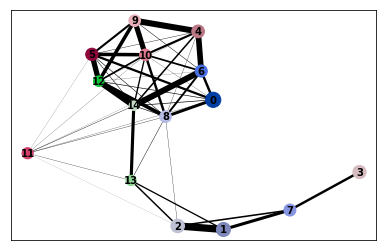

/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, 

/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


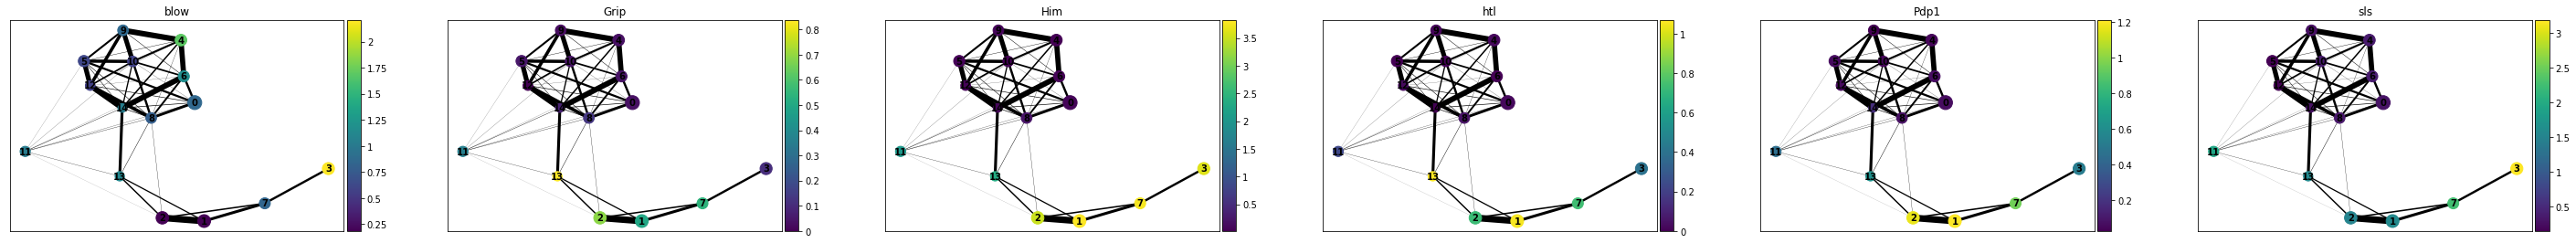

/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, 

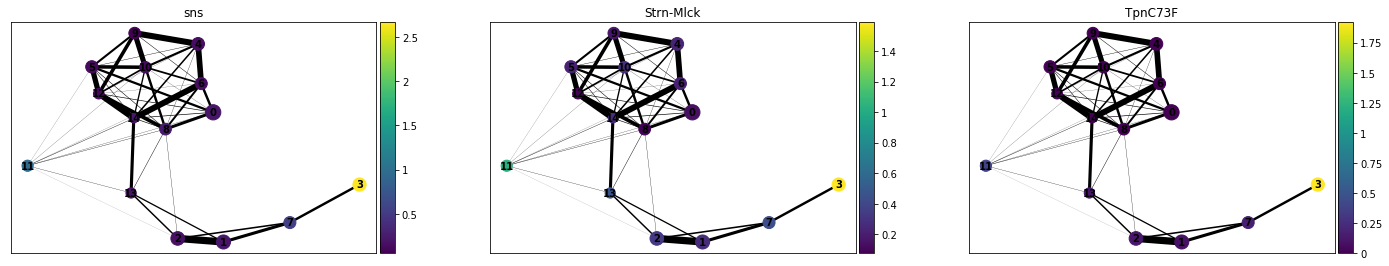

/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, 

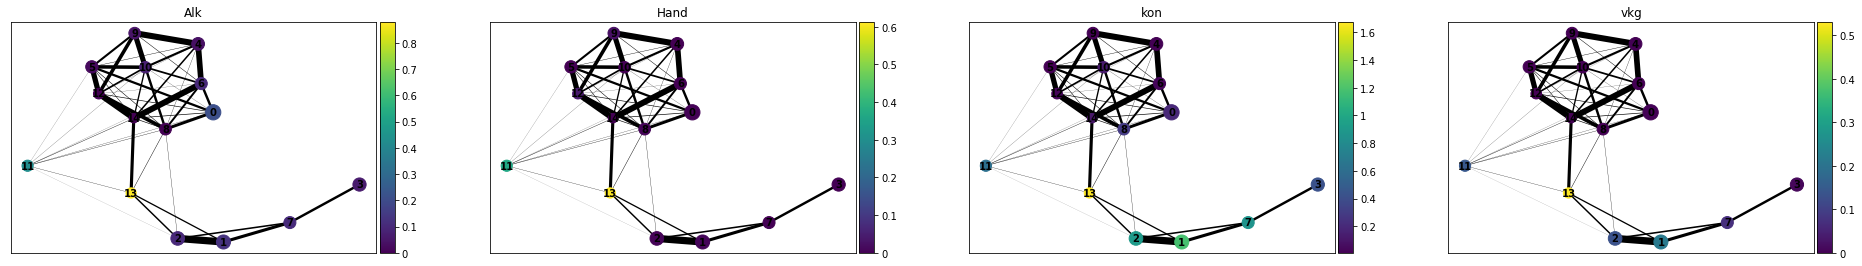

/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, 

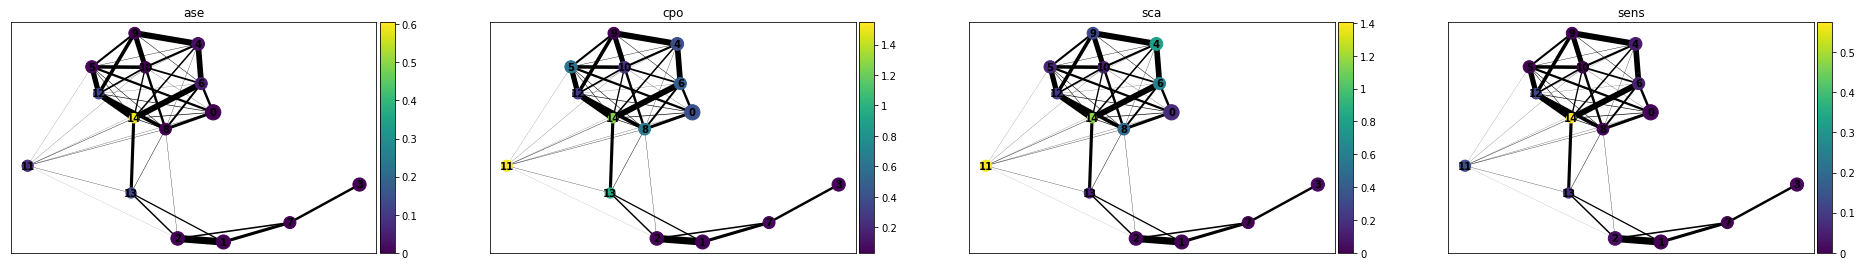

/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, 

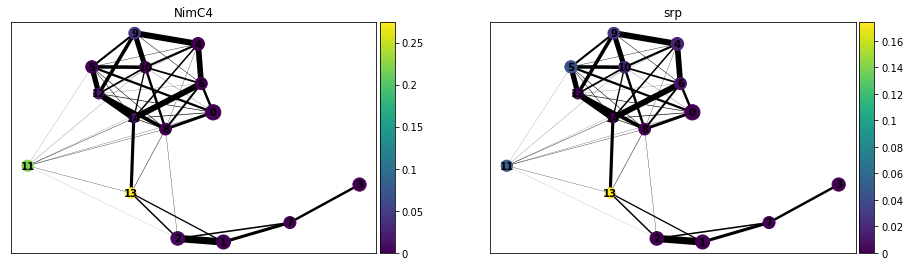

/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, 

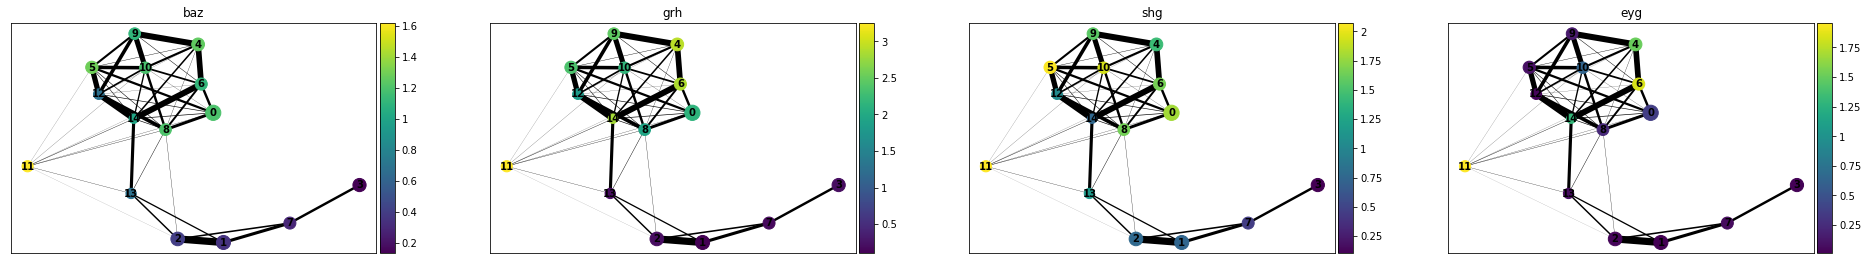

In [60]:
sc.tl.louvain(adata, resolution=1.0)
sc.tl.paga(adata, groups='louvain')
sc.pl.paga(adata, color=['louvain'],save='paga_louvain')
sc.pl.paga(adata, color=list_muscle,save='paga_muscle')#muscle
sc.pl.paga(adata, color=["sns","Strn-Mlck","TpnC73F"],save='paga_pre-muscle')#pre-muscle
sc.pl.paga(adata, color=list_tendon,save='paga_tendon')#tendon
sc.pl.paga(adata, color=list_sop,save='paga_sop')#SOP
sc.pl.paga(adata,color=[ "NimC4",'srp'],save='paga_hemo')#hemo
sc.pl.paga(adata, color=['baz','grh','shg','eyg'],save='paga_epi')#epithelial



Validation

/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, 

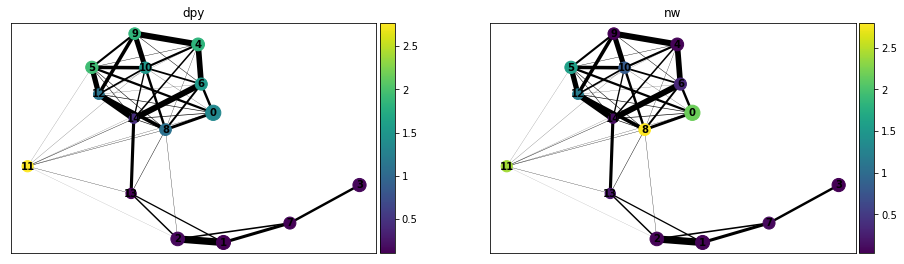

/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, 

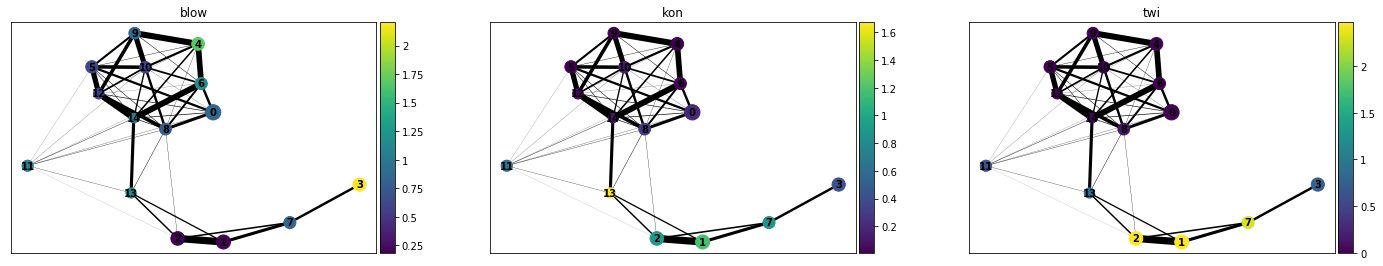

/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/Users/kenzakadri/PycharmProjects/M2BS/venvtest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, 

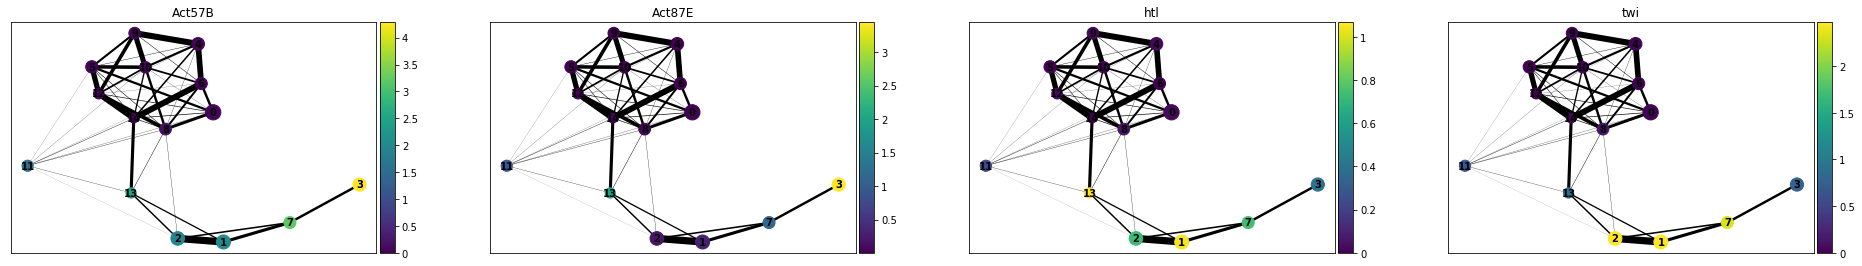

In [61]:
sc.pl.paga(adata, color=["dpy","nw"],save='pagavalep')#epithelialval
sc.pl.paga(adata,color=[ "blow","kon","twi"],save='pagavalmuscle')#muscle
sc.pl.paga(adata, color=["Act57B",'Act87E',"htl","twi"],save='pagavalautre')#tout sauf epithelial

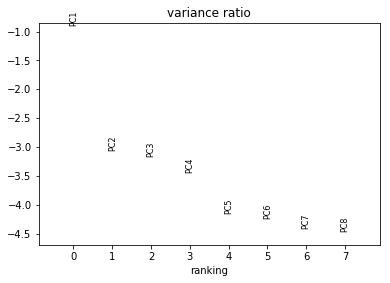

In [62]:
sc.pl.pca_variance_ratio(adata, log=True)


In [63]:
results_file = './write/pbmc3k.h5ad'  # the file that will store the analysis results

adata.write(results_file)


In [64]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=8)


In [65]:
sc.tl.umap(adata)


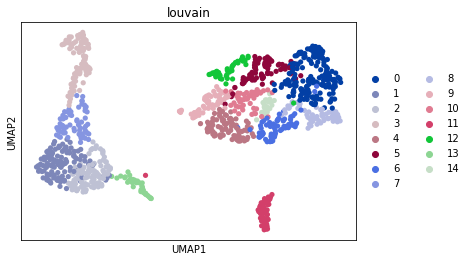

In [66]:
sc.pl.umap(adata, color=['louvain'],save=True)


In [67]:
adata.write(results_file)


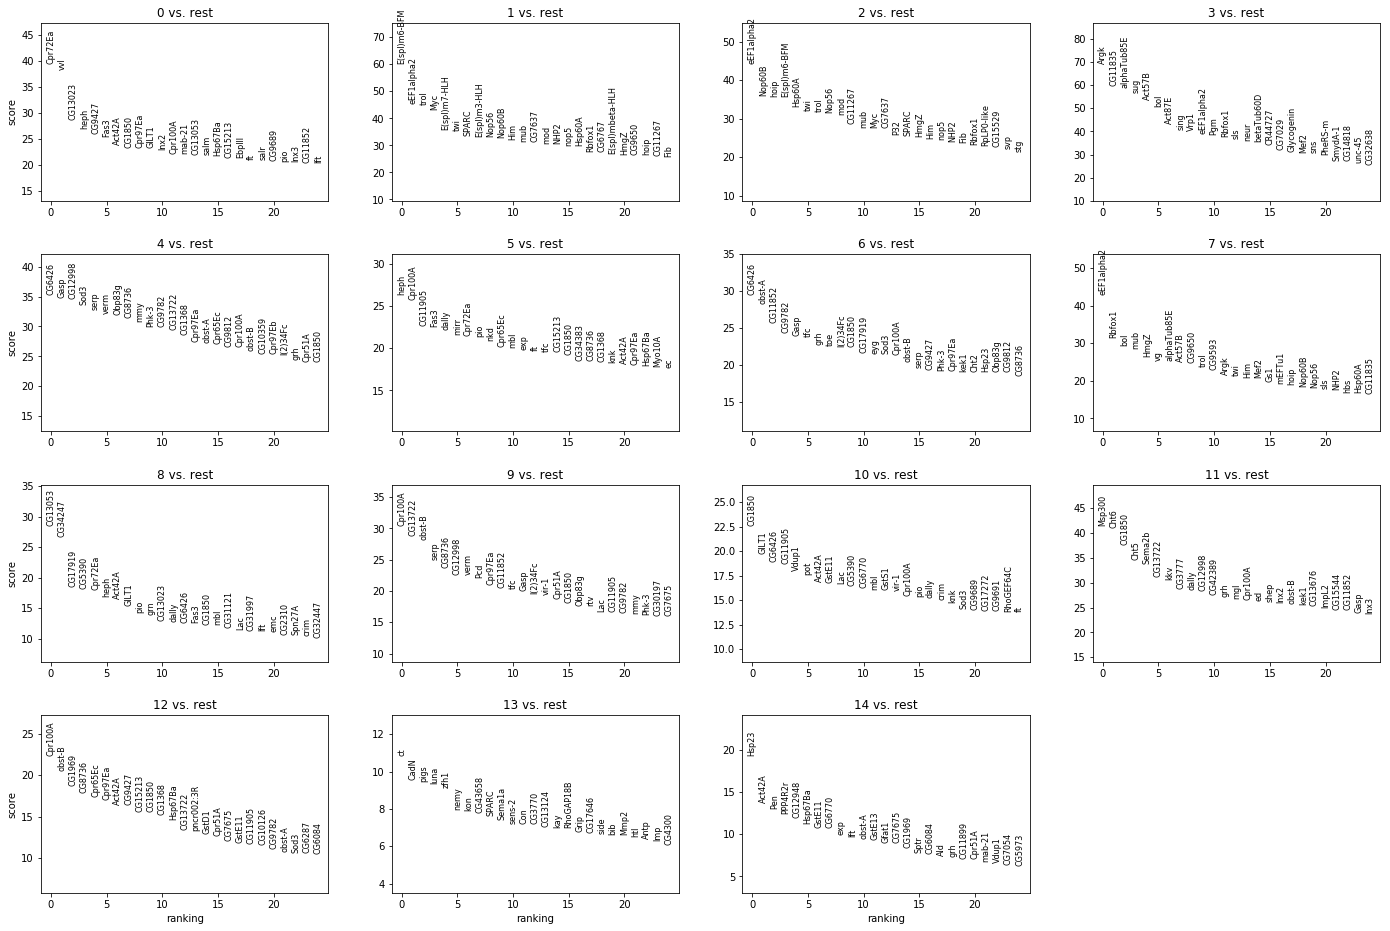

In [68]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [69]:
adata.write(results_file)


In [70]:
marker_genes = ["dpy","nw","blow","kon","twi","Act57B","Act87E","htl","grip","twi"]

In [71]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Cpr72Ea,E(spl)m6-BFM,eEF1alpha2,Argk,CG6426,heph,CG6426,eEF1alpha2,CG13053,Cpr100A,CG1850,Msp300,Cpr100A,ct,Hsp23
1,vvl,eEF1alpha2,Nop60B,CG11835,Gasp,Cpr100A,obst-A,Rbfox1,CG34247,CG13722,GILT1,Cht6,obst-B,CadN,Act42A
2,CG13023,trol,hoip,alphaTub85E,CG12998,CG11905,CG11852,bol,CG17919,obst-B,CG6426,CG1850,CG1969,pigs,Pen
3,heph,Myc,E(spl)m6-BFM,sug,Sod3,Fas3,CG9782,mub,CG5390,serp,CG11905,Cht5,CG8736,luna,PPP4R2r
4,CG9427,E(spl)m7-HLH,Hsp60A,Act57B,serp,dally,Gasp,HmgZ,Cpr72Ea,CG8736,Vdup1,Sema2b,Cpr65Ec,zfh1,CG12948


In [72]:

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p,14_n,14_p
0,Cpr72Ea,1.346101e-189,E(spl)m6-BFM,7.208152e-317,eEF1alpha2,5.096822e-245,Argk,8.701448e-210,CG6426,1.368719e-138,...,CG1850,9.497769e-67,Msp300,6.421932e-58,Cpr100A,5.421838e-52,ct,9.503453e-13,Hsp23,1.253742e-19
1,vvl,2.778126e-110,eEF1alpha2,6.991636e-252,Nop60B,1.847712e-159,CG11835,5.354418e-107,Gasp,3.102627e-89,...,GILT1,3.279320e-42,Cht6,5.254639e-70,obst-B,1.596752e-37,CadN,2.907429e-11,Act42A,6.379705e-16
2,CG13023,1.409950e-96,trol,2.073963e-217,hoip,7.079911e-123,alphaTub85E,6.307033e-115,CG12998,1.320415e-79,...,CG6426,5.703357e-37,CG1850,4.828274e-153,CG1969,7.201487e-28,pigs,2.783420e-11,Pen,8.777868e-15
3,heph,1.719456e-119,Myc,1.637718e-180,E(spl)m6-BFM,6.216818e-109,sug,8.752092e-82,Sod3,4.308503e-93,...,CG11905,2.633723e-31,Cht5,1.603051e-47,CG8736,8.599597e-28,luna,4.136915e-11,PPP4R2r,2.486141e-13
4,CG9427,2.555295e-109,E(spl)m7-HLH,3.374048e-156,Hsp60A,9.877103e-107,Act57B,3.293357e-137,serp,1.482587e-102,...,Vdup1,8.519034e-34,Sema2b,4.894101e-53,Cpr65Ec,7.346652e-25,zfh1,7.541823e-11,CG12948,1.167918e-12


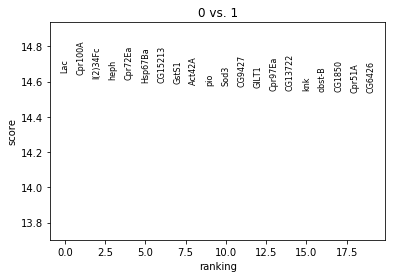

In [73]:
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

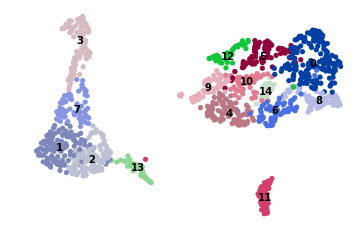

In [75]:
sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False)

In [76]:
adata.obs['louvain'].cat.categories


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14'],
      dtype='object')

In [77]:
muscle  = ["blow","Grip","Him","htl","Pdp1", "sls"]
pre_muscle  = ["sns","Strn-Mlck","TpnC73F"]#"sis"] 
tendon     = ["Alk","Hand","kon","vkg"]
sop        = [ "ase","cpo", "sca","sens"]
hemo       = ["NimC4", "srp"]
epi        = ['baz','grh','shg','eyg']




In [78]:
adata.obs['louvain_anno'] = adata.obs['louvain']


In [79]:
adata.obs['louvain_anno'].cat.categories = ['epi1', 'mucle1', 'muscle2', 'muscle/pre-muscle', 'epi2', 'epi3', 
                                            'epi4', 'muscle3', 'epi5', 'epi6', 'epi7', 'SOP+epi', 'epi8',
                                            'hemocyte+tendon', 'epithelial+SOP']

In [80]:
sc.tl.paga(adata, groups='louvain_anno')


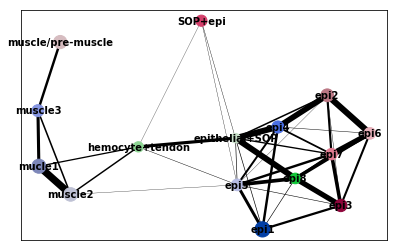

In [81]:
sc.pl.paga(adata, threshold=0.03,save=True)


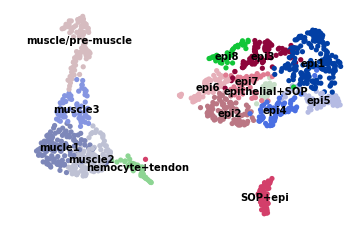

In [82]:
sc.pl.umap(adata, color='louvain_anno', legend_loc='on data', title='', frameon=False, save='.pdf')


In [83]:
adata.obs['louvain_anno']

AAACCCAGTTGCGTAT    muscle3
AAACGAACAGGCTTGC    SOP+epi
AAACGAATCACATTGG       epi2
AAACGCTGTTGGGACA       epi7
AAAGAACTCTATCACT       epi2
                     ...   
TTTCCTCTCAATCAGC     mucle1
TTTCCTCTCATGCAGT       epi6
TTTCGATAGAAGGCTC       epi4
TTTGGAGTCGGCCCAA       epi5
TTTGGTTAGGGATCTG       epi7
Name: louvain_anno, Length: 1098, dtype: category
Categories (15, object): [epi1, mucle1, muscle2, muscle/pre-muscle, ..., SOP+epi, epi8, hemocyte+tendon, epithelial+SOP]

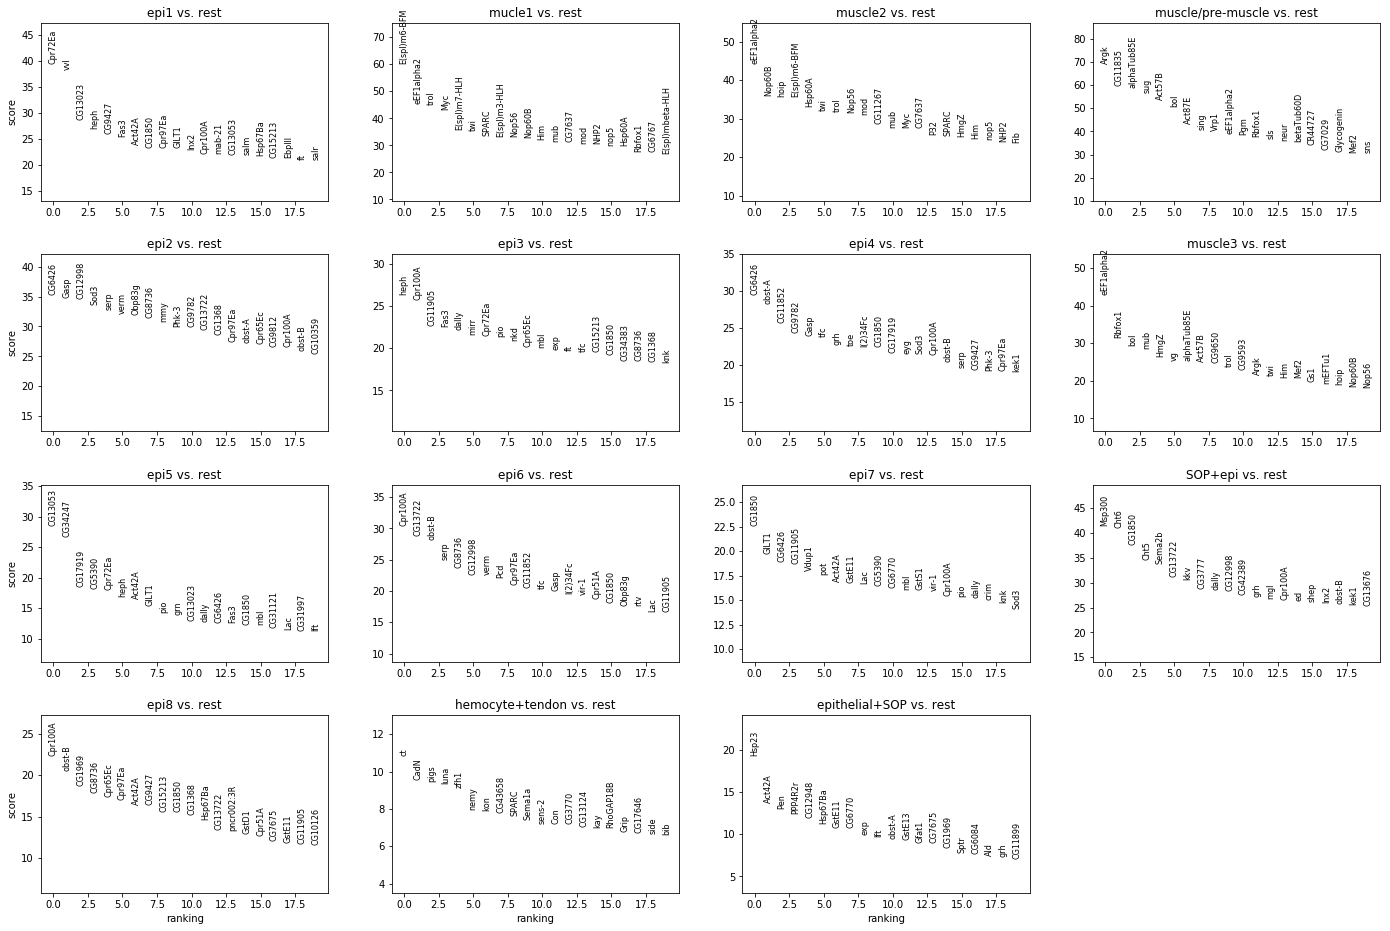

In [84]:
sc.tl.rank_genes_groups(adata, 'louvain_anno', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False,save='ttest')